W tym projekcie zamierzam przedstawić zależności cen lotów od dat lotów. Dane zostały zescrapowane ze strony Kayak, oraz przy założeniu korzystania z usług pośrednika Kiwi.com.

Ceny lotów zostały wyszukane dla jednego miesiąca sierpnia, oraz na jednej trasie, Warszawa-Londyn.

Scraping ściąga dane dla kilkunastu lotów dziennie, co daje ponad 300 rekordów dla cąłego miesiąca.

Scraping odbywa się w pętli, każda iteracja odpowiada wyszukaniu cen lotów dla kolejnego dnia.

Dane są dopisywane przy każdej iteracji do pliku loty.csv



In [103]:
import time

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import lxml
import os

chrome_options = webdriver.ChromeOptions()

def scrap (date_of_flight):


    origin = "WAW"
    destination = "LON"
    startdate = date_of_flight #"2022-09-06"

    url = "https://www.kayak.com/flights/" + origin + "-" + destination + "/" + startdate + "?sort=bestflight_a&fs=stops=0;providers=~SKYPICKER"

    driver = webdriver.Chrome()
    driver.implicitly_wait(10)
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'lxml')

    deptimes = soup.find_all('span', attrs={'class': 'depart-time base-time'})
    arrtimes = soup.find_all('span', attrs={'class': 'arrival-time base-time'})
    prices = soup.find_all('span', attrs={'class': 'price-text'})

    deptime = []
    for div in deptimes:
        deptime.append(div.getText()[:-1])
    #print(deptime)

    arrtime = []
    for div in arrtimes:
        arrtime.append(div.getText()[:-1])

    price = []
    for div in prices:
        price.append(int(div.getText()[2:]))
    print(price)
    print(arrtime)

    if len(deptime) > len(price) :
        deptime = deptime[1::2]




    df = pd.DataFrame({"origin": origin,
                       "destination": destination,
                       "startdate": startdate,
                       "deptime": deptime,
                       #"arrtime": arrtime,
                       "currency": "USD",
                       "price": price,
                       })
    print(df)
    boolcheck = False
    if df.empty:
        boolcheck = False
    else:
        boolcheck = True

                # if file does not exist write header
        if not os.path.isfile('loty.csv'):
           df.to_csv('loty.csv', index=False)
        else: # else it exists so append without writing the header
           df.to_csv('loty.csv', mode='a', index=False, header=False)
           #print("ELSE PLIK JEST")


       # df.to_csv('loty.csv', mode='a', encoding='utf-8', index=False)

    driver.close()
    time.sleep(3)

    return boolcheck

In [3]:
from datetime import date, timedelta

def daterange(start_date_loop, end_date_loop):
    for n in range(int((end_date_loop - start_date_loop).days)):
        yield start_date_loop + timedelta(n)



In [4]:
from datetime import datetime

start_date_loop = date(2022, 8, 1)
end_date_loop = date(2022, 9, 1)
#for single_date in daterange(start_date_loop, end_date_loop):
#    print(single_date.strftime("%Y-%m-%d"))

single_date = start_date_loop
while single_date in daterange(start_date_loop, end_date_loop):
    print(single_date.strftime("%Y-%m-%d"))
    if scrap(single_date.strftime("%Y-%m-%d")):
        single_date = single_date + timedelta(days=1)




2022-08-01
[32, 36, 36, 40, 49, 49, 188, 234, 226, 231]
['12:05', '12:05', '9:30', '9:30', '6:20', '6:20', '7:40', '7:40', '7:10', '7:10', '1:45', '1:45', '9:25', '9:25', '9:55', '9:55', '8:05', '8:05', '5:20', '5:20']
  origin destination   startdate deptime currency  price
0    WAW         LON  2022-08-01   10:40      USD     32
1    WAW         LON  2022-08-01    8:05      USD     36
2    WAW         LON  2022-08-01    4:55      USD     36
3    WAW         LON  2022-08-01    6:05      USD     40
4    WAW         LON  2022-08-01    5:35      USD     49
5    WAW         LON  2022-08-01   12:10      USD     49
6    WAW         LON  2022-08-01    7:35      USD    188
7    WAW         LON  2022-08-01    8:10      USD    234
8    WAW         LON  2022-08-01    6:25      USD    226
9    WAW         LON  2022-08-01    3:30      USD    231
2022-08-02
[23, 24, 29, 38, 45, 140, 221, 226, 226, 226]
['7:40', '8:30', '7:10', '8:20', '2:00', '9:25', '5:20', '8:00', '1:35', '10:25']
  origin destin

Następnie dane są odczytane z pliku w celu dalszej wizualizacji i analizy.

In [46]:
df = pd.read_csv('loty.csv', parse_dates=['startdate'])

print(df)

    origin destination  startdate deptime currency  price
0      WAW         LON 2022-08-01   10:40      USD     32
1      WAW         LON 2022-08-01    8:05      USD     36
2      WAW         LON 2022-08-01    4:55      USD     36
3      WAW         LON 2022-08-01    6:05      USD     40
4      WAW         LON 2022-08-01    5:35      USD     49
..     ...         ...        ...     ...      ...    ...
320    WAW         LON 2022-08-31    5:35      USD    134
321    WAW         LON 2022-08-31    7:35      USD    196
322    WAW         LON 2022-08-31    8:20      USD    226
323    WAW         LON 2022-08-31    6:10      USD    226
324    WAW         LON 2022-08-31   11:50      USD    226

[325 rows x 6 columns]


Najpierw zostaje pokazana zależność cen do dnia tygodnia w jakim następuje lot. Odbywa się to poprzez konwersje daty na dzień tygodnia, oraz wyciągnięcie średniej z cen, dla poszczególnych dni.

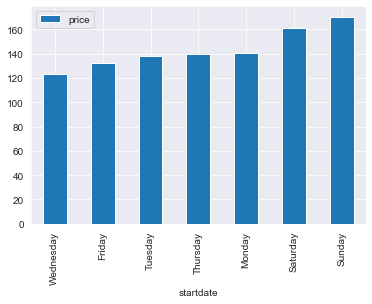

In [51]:
df = pd.read_csv('loty.csv', parse_dates=['startdate'])

df['startdate'] = df['startdate'].dt.strftime("%A")
#week_df = df.groupby(df['startdate'].dt.weekday_name).mean().reindex(days)
df = df.groupby(df['startdate']).mean().sort_values(by=['price']).plot(kind="bar")
#print (df.dtypes)



Możemy zaobserwować znaczy wzrost cen w weekendy, niedziele są średnio najdroższe, poniedziałki najtańsze.

Następnie zostaje wykonana analiza na tej samej zasadzie, jednak zamiast cen średnich dla poszczególnych dni, zostaje wzięta pod uwagę cena najniższa dla danego dnia.

    origin destination  startdate deptime currency  price
0      WAW         LON 2022-08-01   10:40      USD     32
1      WAW         LON 2022-08-01    8:05      USD     36
2      WAW         LON 2022-08-01    4:55      USD     36
3      WAW         LON 2022-08-01    6:05      USD     40
4      WAW         LON 2022-08-01    5:35      USD     49
..     ...         ...        ...     ...      ...    ...
320    WAW         LON 2022-08-31    5:35      USD    134
321    WAW         LON 2022-08-31    7:35      USD    196
322    WAW         LON 2022-08-31    8:20      USD    226
323    WAW         LON 2022-08-31    6:10      USD    226
324    WAW         LON 2022-08-31   11:50      USD    226

[325 rows x 6 columns]


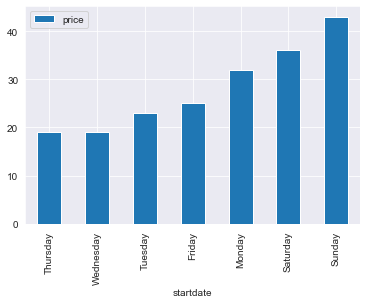

In [54]:
df = pd.read_csv('loty.csv', parse_dates=['startdate'])

print (df)

df['startdate'] = df['startdate'].dt.strftime("%A")
#week_df = df.groupby(df['startdate'].dt.weekday_name).mean().reindex(days)
df = df.groupby(df['startdate']).min().sort_values(by=['price']).plot(kind="bar")

Możemy zaobserwować ponad 2 krotną różnice w cenie przy porównaniu najtańszych dni środy i czwartku, oraz najdrożej niedzieli.

Następnie zostaje przedstawiona heatmapa dla całego miesiąca z uwzględnieniem średnich cen. Tutaj możemy zaobserować droższe ceny w weekendy, jednak najważniejsza jest różnica w cenie jeśli chodzi o dzień w miesiącu.

    startdate       price
0  2022-08-01  112.100000
1  2022-08-02  119.800000
2  2022-08-03  102.083333
3  2022-08-04  118.000000
4  2022-08-05  111.333333
5  2022-08-06  145.500000
6  2022-08-07  142.916667
7  2022-08-08  125.000000
8  2022-08-09  124.900000
9  2022-08-10  117.000000
10 2022-08-11  151.181818
11 2022-08-12  132.583333
12 2022-08-13  158.200000
13 2022-08-14  160.583333
14 2022-08-15  145.636364
15 2022-08-16  146.500000
16 2022-08-17  121.000000
17 2022-08-18  132.555556
18 2022-08-19  130.909091
19 2022-08-20  143.444444
20 2022-08-21  167.166667
21 2022-08-22  153.000000
22 2022-08-23  145.700000
23 2022-08-24  135.636364
24 2022-08-25  156.600000
25 2022-08-26  155.363636
26 2022-08-27  231.000000
27 2022-08-28  214.454545
28 2022-08-29  166.500000
29 2022-08-30  156.666667
30 2022-08-31  142.900000


<AxesSubplot:title={'center':'August'}>

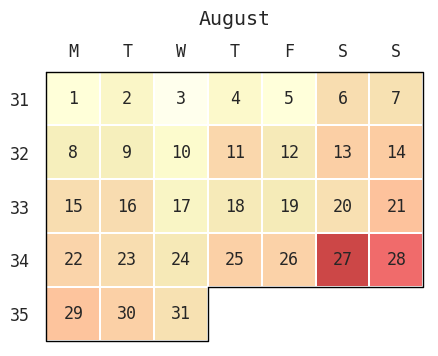

In [74]:
df = pd.read_csv('loty.csv', parse_dates=['startdate'])


import july
from july.utils import date_range
#print(df.groupby(df['startdate']).min())
df = df.groupby(df['startdate'], as_index=False).mean()
df = df[["startdate","price"]]
print(df)
dates = date_range("2022-08-01", "2004-08-31")
#july.heatmap(dates,data=df['startdate'])
july.month_plot(df["startdate"], data=df["price"],date_label=True)

Na początku miesiąca w środku wakacji ceny są najniższe. Im bliżej końca wakacji szkolnych tym loty są droższe. Biorąc pod uwagę średnie ceny, chcąc kupić najtańszy bilet należy kupować bilety na początek miesiąca, na tygodniu.

Następnie zostaje dokonana ta sama analiza, tylko z użyciem danych dotyczących tylko najtańszych połączeń każdego dnia.

    startdate  price
0  2022-08-01     32
1  2022-08-02     23
2  2022-08-03     19
3  2022-08-04     19
4  2022-08-05     25
5  2022-08-06     36
6  2022-08-07     43
7  2022-08-08     43
8  2022-08-09     49
9  2022-08-10     43
10 2022-08-11     43
11 2022-08-12     56
12 2022-08-13     62
13 2022-08-14     49
14 2022-08-15     53
15 2022-08-16     49
16 2022-08-17     48
17 2022-08-18     43
18 2022-08-19     49
19 2022-08-20     56
20 2022-08-21     53
21 2022-08-22     65
22 2022-08-23     43
23 2022-08-24     41
24 2022-08-25     47
25 2022-08-26     56
26 2022-08-27    103
27 2022-08-28     66
28 2022-08-29     66
29 2022-08-30     57
30 2022-08-31     50


<AxesSubplot:title={'center':'August'}>

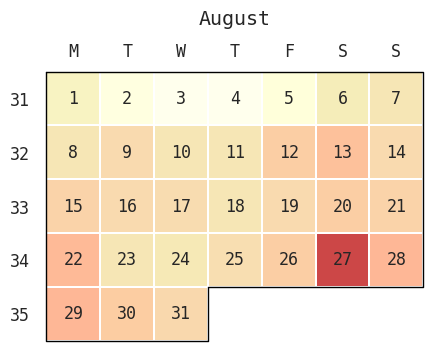

In [97]:
df = pd.read_csv('loty.csv', parse_dates=['startdate'])


import july
from july.utils import date_range
#print(df.groupby(df['startdate']).min())
df = df.groupby(df['startdate'], as_index=False).min()
df = df[["startdate","price"]]
print(df)
dates = date_range("2022-08-01", "2004-08-31")
#july.heatmap(dates,data=df['startdate'])
july.month_plot(df["startdate"], data=df["price"],date_label=True)

Porównując obie heatmapy możemy zaobserwować, że na tygodniu nawet pod koniec miesiąca jest możliwy zakup tanich biletów, jednak trzeba mieć na uwadze, że jeśli najtańsze bilety się wyprzedadzą, to ze względu na wysoką średnią cenę pod koniec miesiąca, jest wysokie ryzyko na bycie zmuszonym do zakupu o wiele droższego biletu.

W przypadku połączeń na początku miesiąca, ilość tanich połączeń jest znacznie większa.

In [102]:
df = pd.read_csv('loty.csv', parse_dates=['startdate'])


import july
from july.utils import date_range
#print(df.groupby(df['startdate']).min())
filter = df["deptime"]


#df = df.loc[df["deptime"].split(":")[0]>12]



#df = df.groupby(df['startdate'], as_index=False).min()
#df = df[["startdate","price"]]
#print(df)
#dates = date_range("2022-08-01", "2004-08-31")
#july.heatmap(dates,data=df['startdate'])
#july.month_plot(df["startdate"], data=df["price"],date_label=True)